<a href="https://colab.research.google.com/github/chani661/NLP-final-project-bert-text-regression/blob/main/NLP_final_project_chani_factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.modeling_outputs import SequenceClassifierOutput
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
import os
warnings.filterwarnings('ignore')

#Consistency of results
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
# definding the labels
QUESTION_LABELS = [
    'question_asker_intent_understanding', 'question_body_critical', 'question_conversational',
    'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
    'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent',
    'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
    'question_type_compare', 'question_type_consequence', 'question_type_definition',
    'question_type_entity', 'question_type_instructions', 'question_type_procedure',
    'question_type_reason_explanation', 'question_type_spelling', 'question_well_written'
]
ANSWER_LABELS = [
    'answer_helpful', 'answer_level_of_information', 'answer_plausible',
    'answer_relevance', 'answer_satisfaction', 'answer_type_instructions',
    'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written'
]
ALL_LABELS = QUESTION_LABELS + ANSWER_LABELS
NUM_LABELS = len(ALL_LABELS)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# getting the data & checking the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    missing = set(ALL_LABELS + ['question_title', 'question_body', 'answer']) - set(df.columns)
    if missing:
        raise ValueError(f"missing value: {missing}")
    return df

In [5]:
# text preprocessing
def advanced_text_preprocessing(df):
    #By [SEP] the model knows where the question ends and the answer begins
    df['processed_text'] = df.apply(
        lambda row: f"{row['question_title']} {row['question_body']} [SEP] {row['answer']}", axis=1
    )
    return df

In [6]:
# creating the dataset
class BERTQADataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], truncation=True, padding='max_length',
            max_length=self.max_length, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(), #adjust dim
            'labels': torch.FloatTensor(self.labels[idx])
        }

In [7]:
# the MODEL with molti-target regression
class BERTMultiTargetRegressor(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_labels=30, dropout_rate=0.3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        hidden_size = self.bert.config.hidden_size
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 4, num_labels),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        logits = self.regressor(cls_output)
        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(logits, labels)
        return SequenceClassifierOutput(loss=loss, logits=logits)

    def unfreeze_bert(self):
        #full training
        for param in self.bert.parameters():
            param.requires_grad = True
        print(" BERT unfreezed – ready for full fine-tuning")

In [8]:
#Tokenizer + Train/Test Split
#actual preperation
def prepare_bert_model_and_data(df, model_name='bert-base-uncased', max_length=512):
    df = advanced_text_preprocessing(df)
    texts = df['processed_text'].tolist()
    labels = df[ALL_LABELS].fillna(0.5).clip(0, 1).astype(np.float32).values
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BERTMultiTargetRegressor(model_name=model_name, num_labels=NUM_LABELS, freeze_bert=True)
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
    train_dataset = BERTQADataset(X_train, y_train, tokenizer, max_length)
    test_dataset = BERTQADataset(X_test, y_test, tokenizer, max_length)
    return model, tokenizer, train_dataset, test_dataset, X_test, y_test

In [9]:
# trainer+early stoping
def train_bert_model(
    model, train_dataset, test_dataset,
    output_dir="./bert_regressor",
    learning_rate=2e-5,
    num_train_epochs=20,
    batch_size=8,
    warmup_ratio=0.1,
    patience=2
):
#define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch", # Changed from evaluation_strategy
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        warmup_ratio=warmup_ratio,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="r2",
        greater_is_better=True,
        logging_dir=f"{output_dir}/logs",
        logging_steps=10,
        save_total_limit=2,
        seed=42,
        report_to="none"

    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_advanced_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
    )
    trainer.train()
    return trainer

In [10]:
# metrics
def compute_advanced_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.clip(predictions, 0, 1)

    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)

    spearman_all = []
    for i in range(labels.shape[1]):
        coef, _ = spearmanr(labels[:, i], predictions[:, i])
        spearman_all.append(coef)

    avg_spearman = np.nanmean(spearman_all)

    return {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'avg_spearman': avg_spearman
    }

In [11]:
# eval & graphs
LABEL_NAMES = ALL_LABELS

def evaluate_model(trainer, test_dataset, y_test, label_names=LABEL_NAMES, max_labels_plot=30):
    predictions = trainer.predict(test_dataset)
    y_pred = np.clip(predictions.predictions, 0, 1)

    overall_mse = mean_squared_error(y_test, y_pred)
    overall_mae = mean_absolute_error(y_test, y_pred)
    overall_r2 = r2_score(y_test, y_pred)

    print(f"MAE: {overall_mae:.4f} | MSE: {overall_mse:.4f} | R²: {overall_r2:.4f}")

    mae_per_label = [mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(len(label_names))]
    r2_per_label = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(len(label_names))]
    spearman_per_label = [spearmanr(y_test[:, i], y_pred[:, i])[0] for i in range(len(label_names))]

    def print_top_bottom(metric_list, metric_name, higher_is_better=True):
        sorted_indices = np.argsort(metric_list)[::-1] if higher_is_better else np.argsort(metric_list)
        print(f"\n Top 3 labels by {metric_name}:")
        for idx in sorted_indices[:3]:
            print(f" {label_names[idx]}: {metric_list[idx]:.4f}")
        print(f"\n Bottom 3 labels by {metric_name}:")
        for idx in sorted_indices[-3:]:
            print(f" {label_names[idx]}: {metric_list[idx]:.4f}")

    print_top_bottom(r2_per_label, "R²", higher_is_better=True)
    print_top_bottom(mae_per_label, "MAE", higher_is_better=False)
    print_top_bottom(spearman_per_label, "Spearman", higher_is_better=True)

    #MAE
    plt.figure(figsize=(12, 6))
    sns.barplot(x=mae_per_label[:max_labels_plot], y=label_names[:max_labels_plot], palette="Blues_d")
    plt.title(" MAE by label (10 first)")
    plt.xlabel("MAE")
    plt.ylabel("Label")
    plt.tight_layout()
    plt.show()

    #R²
    plt.figure(figsize=(12, 6))
    sns.barplot(x=r2_per_label[:max_labels_plot], y=label_names[:max_labels_plot], palette="Greens_d")
    plt.title(" R² by label (10 first)")
    plt.xlabel("R²")
    plt.ylabel("Label")
    plt.tight_layout()
    plt.show()

    # Spearman
    plt.figure(figsize=(12, 6))
    sns.barplot(x=spearman_per_label[:max_labels_plot], y=label_names[:max_labels_plot], palette="Purples_d")
    plt.title("Spearman correlation by label (first 10)")
    plt.xlabel("Spearman")
    plt.ylabel("Label")
    plt.tight_layout()
    plt.show()

    return {
        'mse': overall_mse,
        'mae': overall_mae,
        'r2': overall_r2,
        'avg_label_mae': np.mean(mae_per_label),
        'avg_label_r2': np.mean(r2_per_label),
        'avg_label_spearman': np.nanmean(spearman_per_label),
        'best_label_r2': np.max(r2_per_label),
        'worst_label_r2': np.min(r2_per_label)
    }


Epoch,Training Loss,Validation Loss,Mse,Mae,R2
1,0.098400,0.091182,0.091182,0.263768,-36.073978
2,0.067100,0.060028,0.060028,0.174813,-1.321908
3,0.058900,0.056398,0.056398,0.166129,-0.646862
4,0.061500,0.054857,0.054857,0.163497,-0.430657
5,0.055500,0.054021,0.054021,0.160412,-0.317323
6,0.049000,0.053535,0.053535,0.159059,-0.253941
7,0.058100,0.053143,0.053143,0.157755,-0.177992
8,0.053900,0.052848,0.052848,0.156893,-0.127362
9,0.052800,0.052561,0.052561,0.156582,-0.089970
10,0.057100,0.052389,0.052389,0.155949,-0.053934


MAE: 0.1535 | MSE: 0.0515 | R²: 0.0500


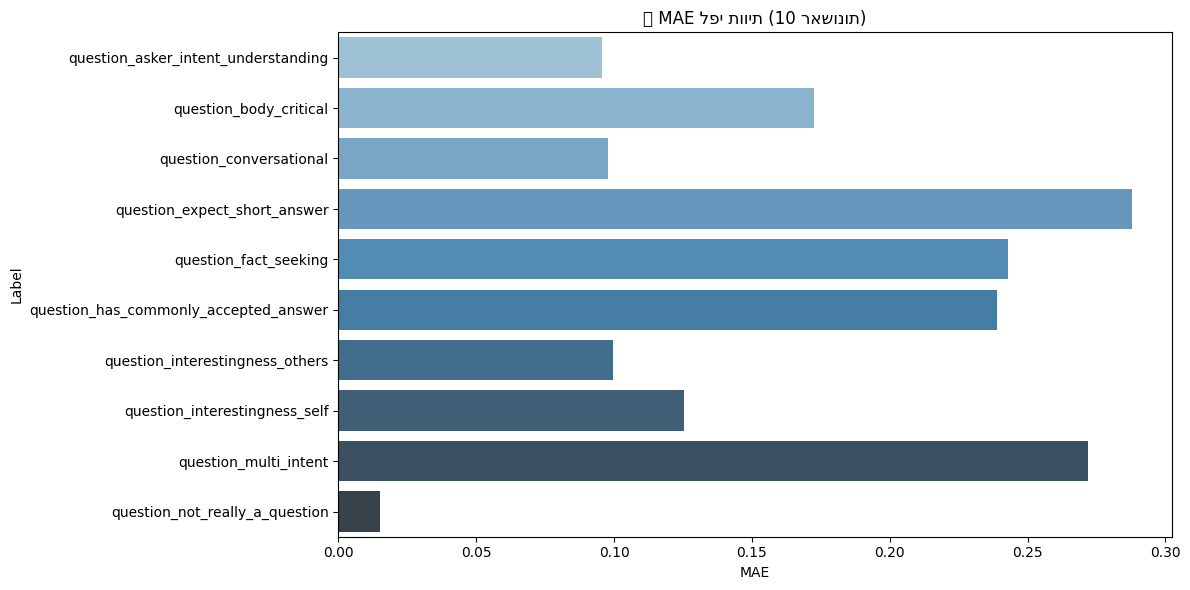

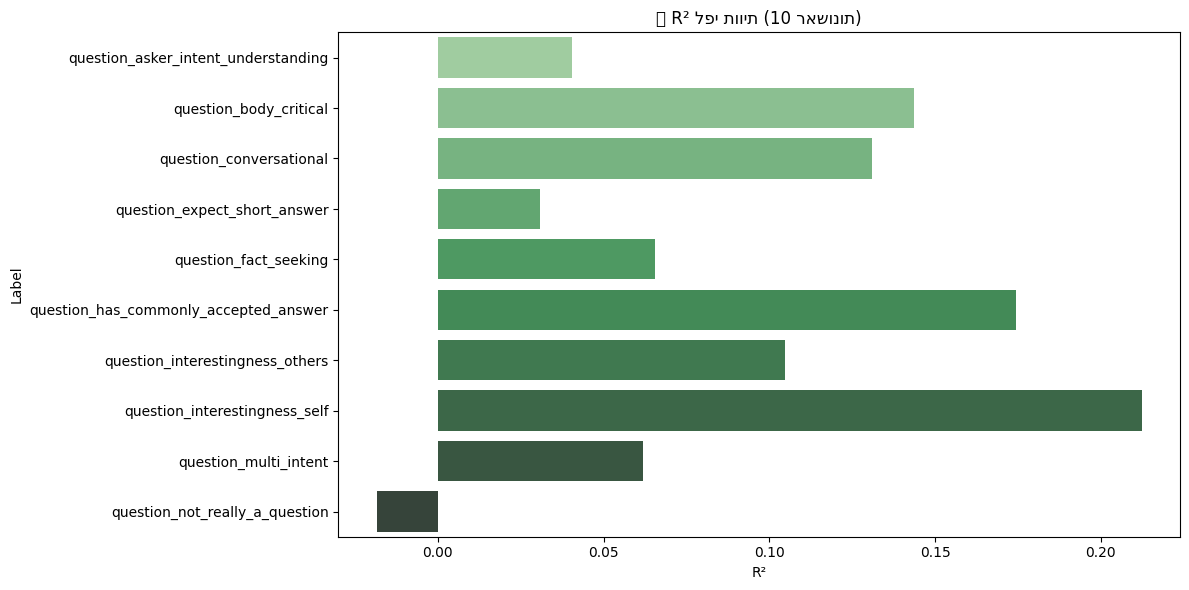

In [ ]:
#
df = load_data('/content/drive/MyDrive/NLP/train.csv')
model, tokenizer, train_dataset, test_dataset, X_test, y_test = prepare_bert_model_and_data(df)
trainer = train_bert_model(model, train_dataset, test_dataset)
results = evaluate_model(trainer, test_dataset, y_test)


# full train

In [ ]:
# full train unfreeze
model.unfreeze_bert()

training_args_stage2 = TrainingArguments(
    output_dir="./bert_regressor_stage2",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="r2",
    greater_is_better=True,
    logging_dir="./bert_regressor_stage2/logs",
    logging_steps=10,
    save_total_limit=2,
    seed=42,
    report_to="none"
)


trainer_stage2 = Trainer(
    model=model,
    args=training_args_stage2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_advanced_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


trainer_stage2.train()


 BERT unfreezed – ready for full fine-tuning


Epoch,Training Loss,Validation Loss,Mse,Mae,R2
1,0.045100,0.045733,0.045733,0.141885,0.103426
2,0.043600,0.043402,0.043402,0.137408,0.123746
3,0.038600,0.042997,0.042997,0.134374,0.134994
4,0.042100,0.042388,0.042388,0.135664,0.147146
5,0.037900,0.042352,0.042352,0.134420,0.150116


TrainOutput(global_step=3040, training_loss=0.04213528732131971, metrics={'train_runtime': 2836.7526, 'train_samples_per_second': 8.571, 'train_steps_per_second': 1.072, 'total_flos': 0.0, 'train_loss': 0.04213528732131971, 'epoch': 5.0})

MAE: 0.1344 | MSE: 0.0424 | R²: 0.1501


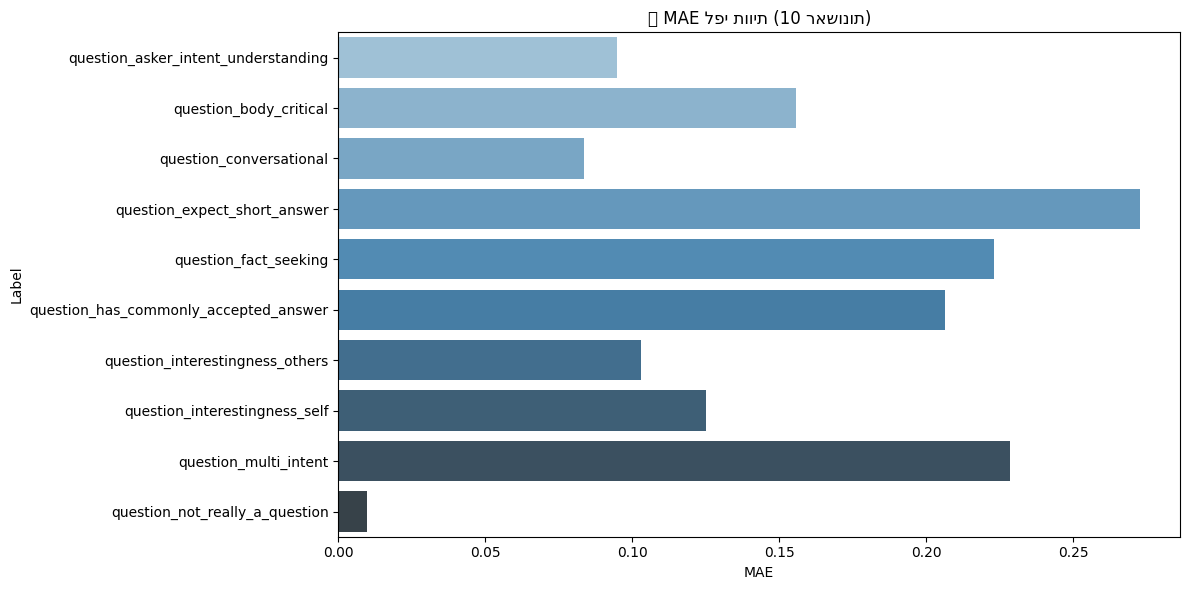

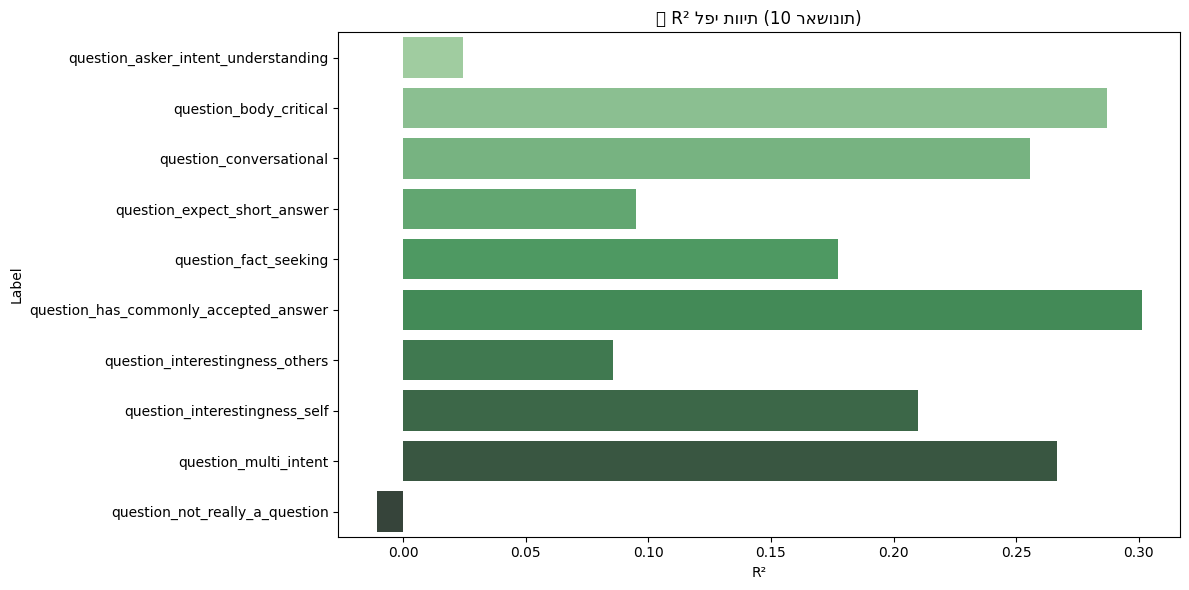

In [ ]:
results = evaluate_model(trainer_stage2, test_dataset, y_test)

# saving model

In [ ]:
model_save_path = "/content/drive/MyDrive/NLP/bert_model_saved"
os.makedirs(model_save_path, exist_ok=True)

# save weights
torch.save(model.state_dict(), os.path.join(model_save_path, "model_weights.pth"))

# save tokenizer
tokenizer.save_pretrained(model_save_path)

print("tokenizer and weught saved to google drive")


✅ נשמרו המשקולות וה-tokenizer לדרייב!


In [ ]:
!cp -r /content/bert_regressor /content/drive/MyDrive/NLP/

# relaod model, weights & tokenizer

In [12]:
# new model object
model = BERTMultiTargetRegressor(model_name='bert-base-uncased', num_labels=NUM_LABELS)
model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/bert model/bert_model_saved/model_weights.pth"))
model.eval()

# laod tokenizer:
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/NLP/bert model/bert_model_saved")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [13]:
# laod data
df = load_data('/content/drive/MyDrive/NLP/train.csv')

# text preprocessing
df = advanced_text_preprocessing(df)
texts = df['processed_text'].tolist()
labels = df[ALL_LABELS].fillna(0.5).clip(0, 1).astype(np.float32).values

# test dataset
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [14]:
test_dataset = BERTQADataset(X_test, y_test, tokenizer)

In [15]:
from transformers import Trainer, TrainingArguments

eval_args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=8,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=eval_args,
    compute_metrics=compute_advanced_metrics
)


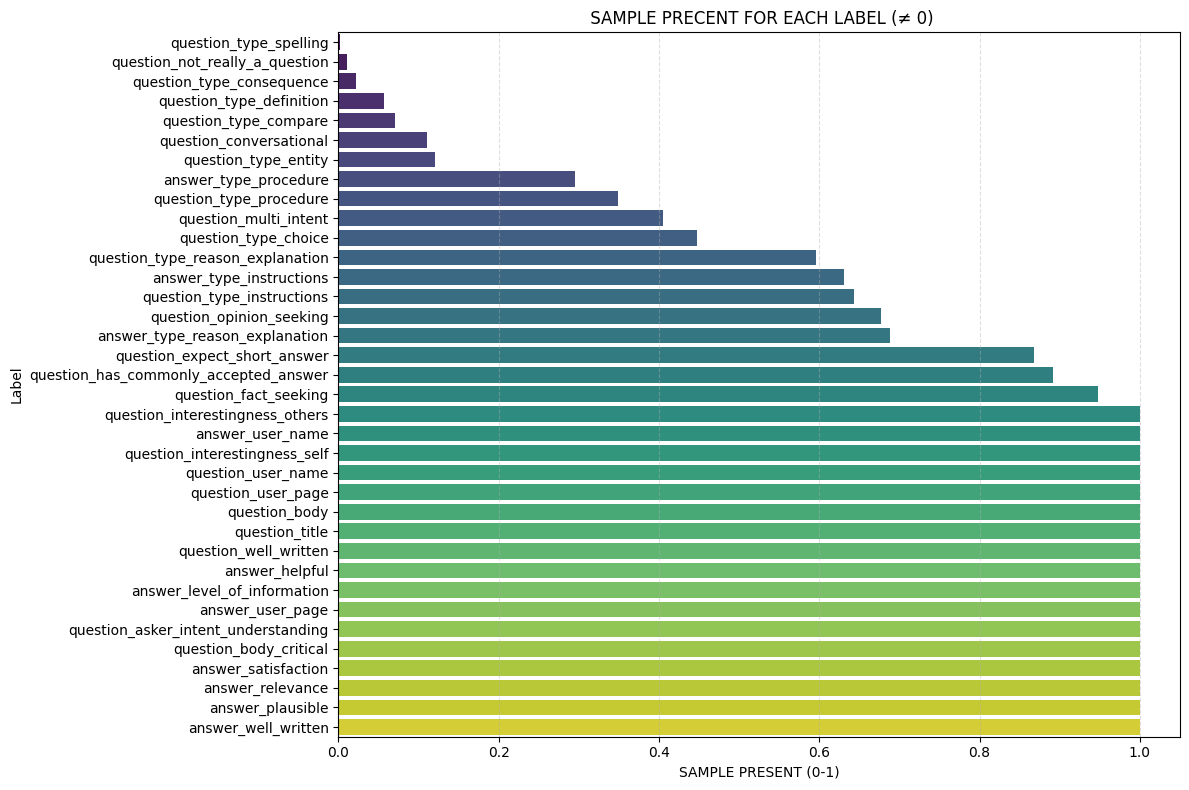

,Fraction_non_zero
question_type_spelling,0.18%
question_not_really_a_question,1.09%
question_type_consequence,2.15%
question_type_definition,5.66%
question_type_compare,7.02%
question_conversational,11.02%
question_type_entity,12.03%
answer_type_procedure,29.58%
question_type_procedure,34.89%
question_multi_intent,40.50%


In [16]:
#  label distrubution in the data
labels_list = [col for col in df.columns if col.startswith("question_") or col.startswith("answer_")]

# calculating the precentage of labels that !=0
label_frequencies = df[labels_list].astype(bool).mean().sort_values()

# visualization
plt.figure(figsize=(12, 8))
sns.barplot(x=label_frequencies.values, y=label_frequencies.index, palette="viridis")
plt.title(" SAMPLE PRECENT FOR EACH LABEL (≠ 0)")
plt.xlabel("SAMPLE PRESENT (0-1)")
plt.ylabel("Label")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
label_frequencies.to_frame("Fraction_non_zero").style.format("{:.2%}")


# specipic exemple

In [17]:
idx = 42


In [18]:
print("כותרת השאלה:\n", df.iloc[idx]['question_title'])
print("\nגוף השאלה:\n", df.iloc[idx]['question_body'])
print("\nהתשובה:\n", df.iloc[idx]['answer'])


כותרת השאלה:
 Directory.GetFiles string gives an error

גוף השאלה:
 I am creating a website using asp.net and c#
I need to access all files one by one in a directory. So I wrote the following code.

    string[] ssImgs = Directory.GetFiles("images/movies");
    Label1.Text = ssImgs[0];
    Label2.Text = ssImgs[1];


But it gives an error. What is the correct way to do this? Thanks in advance.


התשובה:
 There are two potential issues here.


If you doing have using System.IO; in your file, the Directory class will not be found by the compiler.
The way you're specifying your path ("images/movies") will be relative to the current working directory, which is likely not the proper directory.  You should use Server.MapPath or the Path class to build a full path to the proper folder, so you can specify the correct folder with a full, absolute path.




In [19]:
from transformers import BertTokenizer

text = f"{df.iloc[idx]['question_title']} {df.iloc[idx]['question_body']} [SEP] {df.iloc[idx]['answer']}"
encoding = tokenizer(
    text,
    truncation=True,
    padding='max_length',
    max_length=512,
    return_tensors='pt'
)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move model to the device

model.eval()
with torch.no_grad():
    output = model(
        input_ids=encoding['input_ids'].to(device), # Move input tensors to the device
        attention_mask=encoding['attention_mask'].to(device) # Move input tensors to the device
    )
preds = output.logits.cpu().numpy().flatten()

In [22]:
true_vals = df.iloc[idx][ALL_LABELS].values.astype(np.float32)

for label, true_val, pred in zip(ALL_LABELS, true_vals, preds):
    print(f"{label}:  אמת = {true_val:.2f} | תחזית = {pred:.2f}")


question_asker_intent_understanding:  אמת = 0.89 | תחזית = 0.85
question_body_critical:  אמת = 0.33 | תחזית = 0.41
question_conversational:  אמת = 0.00 | תחזית = 0.01
question_expect_short_answer:  אמת = 1.00 | תחזית = 0.72
question_fact_seeking:  אמת = 0.67 | תחזית = 0.78
question_has_commonly_accepted_answer:  אמת = 1.00 | תחזית = 0.91
question_interestingness_others:  אמת = 0.44 | תחזית = 0.52
question_interestingness_self:  אמת = 0.33 | תחזית = 0.39
question_multi_intent:  אמת = 0.00 | תחזית = 0.13
question_not_really_a_question:  אמת = 0.00 | תחזית = 0.00
question_opinion_seeking:  אמת = 0.67 | תחזית = 0.48
question_type_choice:  אמת = 0.00 | תחזית = 0.08
question_type_compare:  אמת = 0.00 | תחזית = 0.01
question_type_consequence:  אמת = 0.00 | תחזית = 0.00
question_type_definition:  אמת = 0.00 | תחזית = 0.01
question_type_entity:  אמת = 0.00 | תחזית = 0.03
question_type_instructions:  אמת = 1.00 | תחזית = 0.89
question_type_procedure:  אמת = 0.00 | תחזית = 0.21
question_type_reas

In [23]:
import pandas as pd

comparison = pd.DataFrame({
    "Label": ALL_LABELS,
    "True Value": true_vals,
    "Predicted": preds
})
comparison["Error"] = (comparison["Predicted"] - comparison["True Value"]).abs()
comparison.sort_values("Error", ascending=False).head(10)


,Label,True Value,Predicted,Error
18,question_type_reason_explanation,0.666667,0.375294,0.291373
3,question_expect_short_answer,1.000000,0.717426,0.282574
28,answer_type_reason_explanation,0.666667,0.437234,0.229433
17,question_type_procedure,0.000000,0.208939,0.208939
26,answer_type_instructions,0.666667,0.864719,0.198052
27,answer_type_procedure,0.000000,0.189361,0.189361
10,question_opinion_seeking,0.666667,0.480826,0.185841
8,question_multi_intent,0.000000,0.127722,0.127722
4,question_fact_seeking,0.666667,0.775617,0.108950
16,question_type_instructions,1.000000,0.891181,0.108819


MAE: 0.1344 | MSE: 0.0424 | R²: 0.1501

 Top 3 labels by R²:
 question_type_instructions: 0.6240
 question_type_choice: 0.5422
 answer_type_instructions: 0.5323

 Bottom 3 labels by R²:
 answer_plausible: -0.0577
 answer_well_written: -0.1039
 question_type_spelling: -0.2598

 Top 3 labels by MAE:
 question_type_spelling: 0.0033
 question_not_really_a_question: 0.0098
 question_type_consequence: 0.0186

 Bottom 3 labels by MAE:
 answer_type_reason_explanation: 0.2667
 question_opinion_seeking: 0.2727
 question_expect_short_answer: 0.2727

 Top 3 labels by Spearman:
 question_type_instructions: 0.7610
 question_type_choice: 0.7313
 answer_type_instructions: 0.7261

 Bottom 3 labels by Spearman:
 question_type_consequence: 0.0310
 question_not_really_a_question: 0.0004
 question_type_spelling: -0.0421


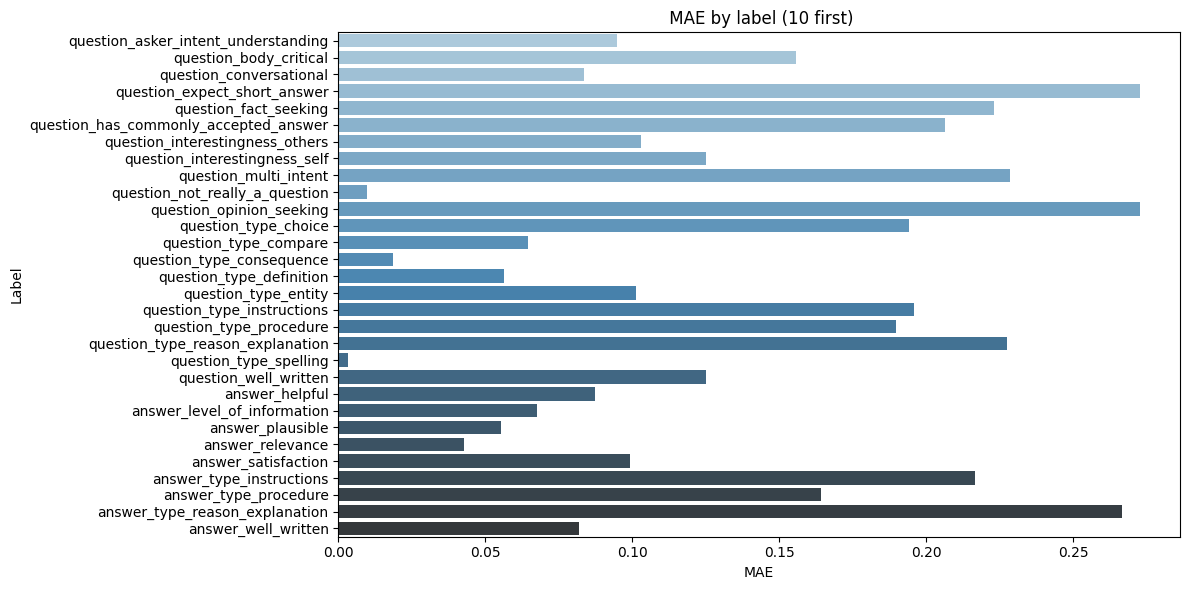

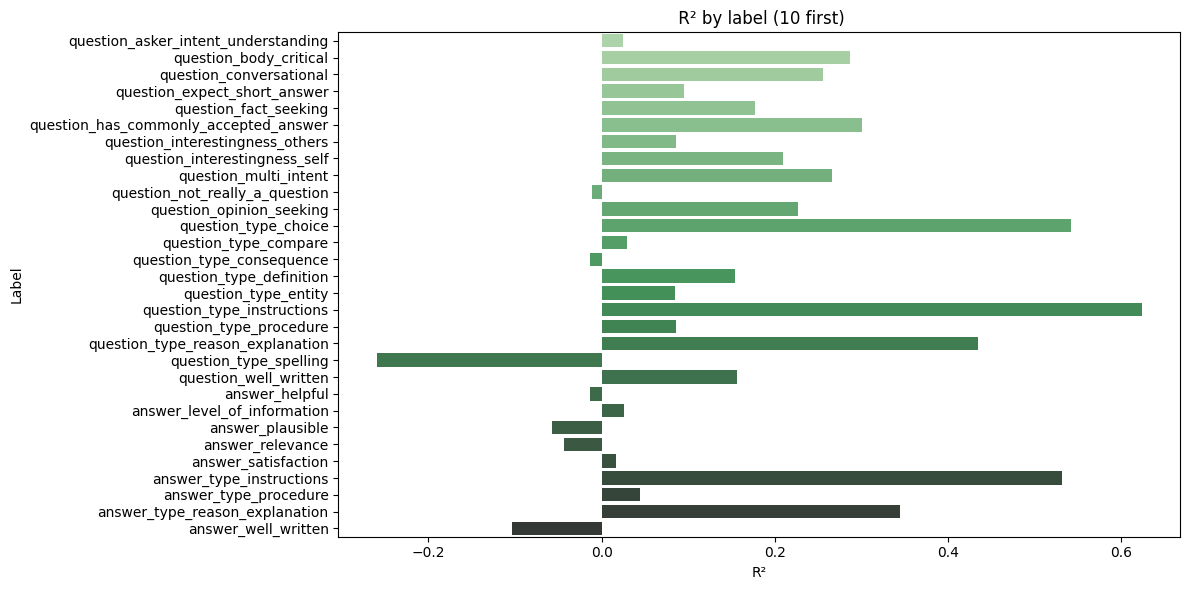

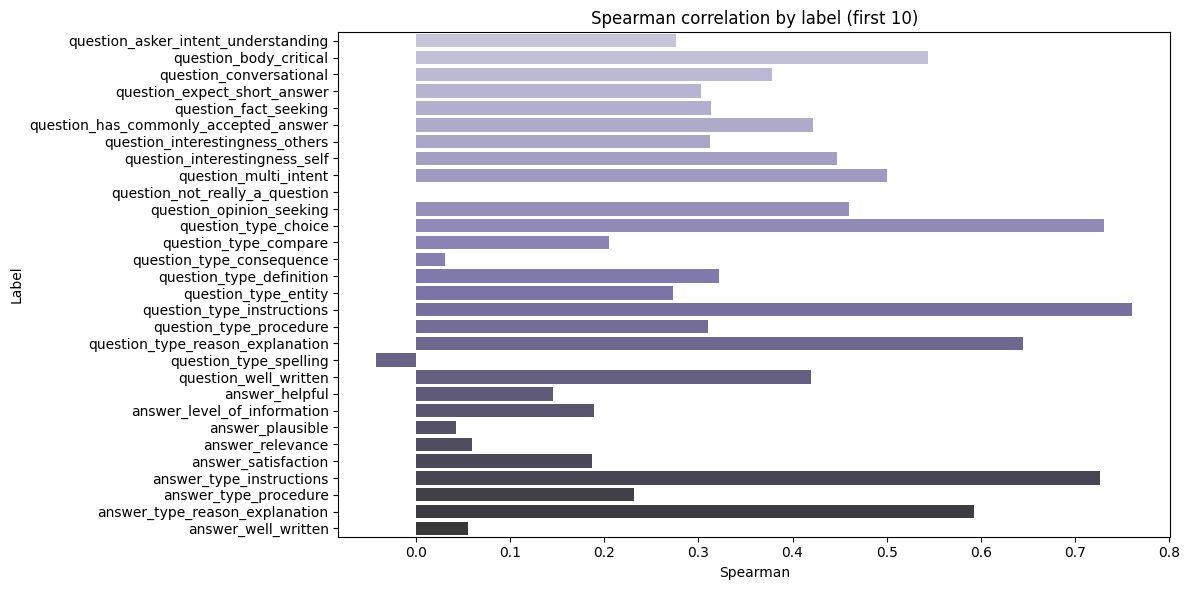

In [ ]:
results = evaluate_model(trainer, test_dataset, y_test)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
import torch

# Define dummy inputs compatible with the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_inputs = {
    "input_ids": torch.randint(0, 1000, (8, 512)).to(device),
    "attention_mask": torch.ones((8, 512), dtype=torch.int64).to(device)
}

model.to(device) # Ensure model is on the correct device
summary(model, input_data=dummy_inputs, col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #
BERTMultiTargetRegressor                                     --                        [8, 30]                   --
├─BertModel: 1-1                                             --                        [8, 768]                  --
│    └─BertEmbeddings: 2-1                                   --                        [8, 512, 768]             --
│    │    └─Embedding: 3-1                                   [8, 512]                  [8, 512, 768]             23,440,896
│    │    └─Embedding: 3-2                                   [8, 512]                  [8, 512, 768]             1,536
│    │    └─Embedding: 3-3                                   [1, 512]                  [1, 512, 768]             393,216
│    │    └─LayerNorm: 3-4                                   [8, 512, 768]             [8, 512, 768]             1,536
│    │    └─Dropout: 3-5                        

In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 644.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 420.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 710.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from torchviz import make_dot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = {
    "input_ids": torch.randint(0, 100, (1, 512)).to(device),
    "attention_mask": torch.ones((1, 512)).to(device)
}

model.to(device) # Ensure model is on the correct device
output = model(**inputs)
make_dot(output.logits, params=dict(model.named_parameters())).render("model_architecture", format="png")

'model_architecture.png'